**Imported Libraries**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import string
from gensim.parsing.preprocessing import remove_stopwords
import matplotlib.pylab as plt
import scipy.sparse as sparse
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
import numpy as np

**Case Stories**

https://docs.google.com/spreadsheets/d/1lwCBkdWXodfrNLjVWqiROqkDpn6OiIky7nwZGgtgXyk/edit#gid=0

**Case Referral Docs**

[Sheet Used as Data in csv format](https://docs.google.com/spreadsheets/d/1cASt5wZROqFT_9kVZk8Ie5YD0E4GRzQlMkglqB2j5h4/edit?usp=sharing)

### Minimal Preprocessing

**Helpful preprocessing from Funke's imptl**

In [ ]:
# Contraction Mapping

!pip install contractions
import contractions

# Applying contraction mapping -Expand Contractions

background_df['Background information'] = background_df['Background information'].apply(lambda x: [contractions.fix(word) for word in x.split()])
background_df

**Actual Preprocessing**

In [ ]:
df = pd.read_csv('Compiled Cases -Project ISS - Sheet1.csv')

# str.maketrans(concatenated string of old, conc string of new, conc string to remove)
# You can also pass a dictionary instead of three strings
df['Case'] = df['Case'].map(
    lambda x: x.translate(str.maketrans('', '', string.punctuation)))

# background_df['Background information'] = background_df['Background information'].str.lower()

df['Case'] = df['Case'].map(
    lambda x: x.lower())

df['Case'] = df['Case'].map(
    lambda x: remove_stopwords(x))

doc_series = df['Case']
# for i in doc_series:


vectorizer = TfidfVectorizer()
# document-term matrix of size (documents, words)
response = vectorizer.fit_transform(doc_series)
print(response)
# response


In [ ]:
vectorizer.get_feature_names()

In [ ]:
response.shape

(205, 6134)

**Visualization of Document-term Matrix**

In [ ]:
# visualize the sparse matrix with Spy
# find a way to show different shades of a color for each value
# plt.spy(response, aspect='auto')
plt.spy(response, aspect='auto', cmap=plt.cm.Spectral)

In [ ]:
vectorizer.get_feature_names()[383]
# vectorizer.get_feature_names()

'actingas'

In [ ]:
response[4, 383]
response[4,]

<1x767 sparse matrix of type '<class 'numpy.float64'>'
	with 221 stored elements in Compressed Sparse Row format>

### Cosine Similarity of Documents

In [ ]:
cosine_similarity(response[4,], response[3,])
# Out[4]: array([[0.7498213]])

array([[0.27125136]])

Based on this [colab notebook](https://colab.research.google.com/github/varun21290/medium/blob/master/Document_Similarities.ipynb#scrollTo=nayjN8Vrodod)

**Just a cool function I saw online haha**

In [ ]:
def most_similar(doc_id,similarity_matrix,matrix):
    print (f'Document: {documents_df.iloc[doc_id]["documents"]}')
    print ('\n')
    print (f'Similar Documents using {matrix}:')
    if matrix=='Cosine Similarity':
        similar_ix=np.argsort(similarity_matrix[doc_id])[::-1]
    elif matrix=='Euclidean Distance':
        similar_ix=np.argsort(similarity_matrix[doc_id])
    for ix in similar_ix:
        if ix==doc_id:
            continue
        print('\n')
        print (f'Document: {documents_df.iloc[ix]["documents"]}')
        print (f'{matrix} : {similarity_matrix[doc_id][ix]}')

In [ ]:
?TfidfVectorizer.*

### K-Means on all Case Stories

**Implementation based on this [article](http://brandonrose.org/clustering?ref=dzone)**

In [ ]:
from sklearn.cluster import KMeans

num_clusters = 5

km = KMeans(n_clusters=num_clusters)

%time km.fit(response)

clusters = km.labels_.tolist()

CPU times: user 2.8 s, sys: 1.97 s, total: 4.78 s
Wall time: 2.45 s


In [ ]:
len(clusters)

205

In [ ]:


from sklearn.externals import joblib

#uncomment the below to save your model 
#since I've already run my model I am loading from the pickle

# joblib.dump(km,  'doc_cluster.pkl')

km = joblib.load('doc_cluster.pkl')
clusters = km.labels_.tolist()



In [ ]:
cases = { 'id': df.ID, 'Case': df.Case, 'cluster': clusters}

frame = pd.DataFrame(cases , columns = ['ID', 'Case', 'cluster'])

In [ ]:
frame['cluster'].value_counts()

4    80
0    57
1    33
2    25
3    10
Name: cluster, dtype: int64

In [ ]:
my_map = vectorizer.vocabulary_
inv_map = {v: k for k, v in my_map.items()}
inv_map

'brighter'

In [ ]:
# vectorizer.get_feature_names()

In [ ]:
# vocab_list = [ inv_map[int(x)] for x in vectorizer.get_feature_names()]
vocab_frame = pd.Series({'word':vectorizer.get_feature_names()})

In [ ]:
vocab_frame.head()
vocab = vectorizer.vocabulary_
word_list = vectorizer.get_feature_names()

In [ ]:
from __future__ import print_function

print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    
    for ind in order_centroids[i, :10]: #replace 6 with n words per cluster
        # print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
        print(word_list[ind], end=',')
    print() #add whitespace
    print() #add whitespace
    '''
    print("Cluster %d titles:" % i, end='')
    for title in frame.ix[i]['title'].values.tolist():
        print(' %s,' % title, end='')
    print() #add whitespace
    print() #add whitespace
    '''

Top terms per cluster:

Cluster 0 words:client,abuse,claim,school,higgins,council,sexual,compensation,church,abused,

Cluster 1 words:scout,abuse,claim,mr,clients,association,suffered,group,years,kemp,

Cluster 2 words:afghanistan,journey,uncle,iran,boys,taliban,smuggler,country,norway,family,

Cluster 3 words:iss,javier,germany,care,grandparents,father,usa,mexico,sophia,rudolf,

Cluster 4 words:mother,children,child,family,care,home,father,baby,social,school,





**We can do ward clustering (agglomerative using cosine matrix then dendogram) using scipy as well**

### Visualizing the Clusters

**from Funke's imptl**

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=3)
np.set_printoptions(suppress=True)
# i think Funke used a glove word representation and not a tfidf
T = tsne.fit_transform(response)
# labels = unique_words
labels = word_list

plt.figure(figsize=(30, 20))
plt.scatter(T[:, 0], T[:, 1], c='blue', edgecolors='b')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

**Implementation based on this [article](http://brandonrose.org/clustering?ref=dzone)**

In [ ]:
dist = 1 - cosine_similarity(response)

In [ ]:


import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]
print()
print()



In [ ]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

#set up cluster names using a dict
cluster_names = {0: 'client, abuse, claim', 
                 1: 'scout, abuse, claim', 
                 2: 'afghanistan, journey, uncle, iran, boys', 
                 3: 'iss, javier, germany, care', 
                 4: 'mother, children, child, family'}

UPDATE: This is not yet how I want it to work

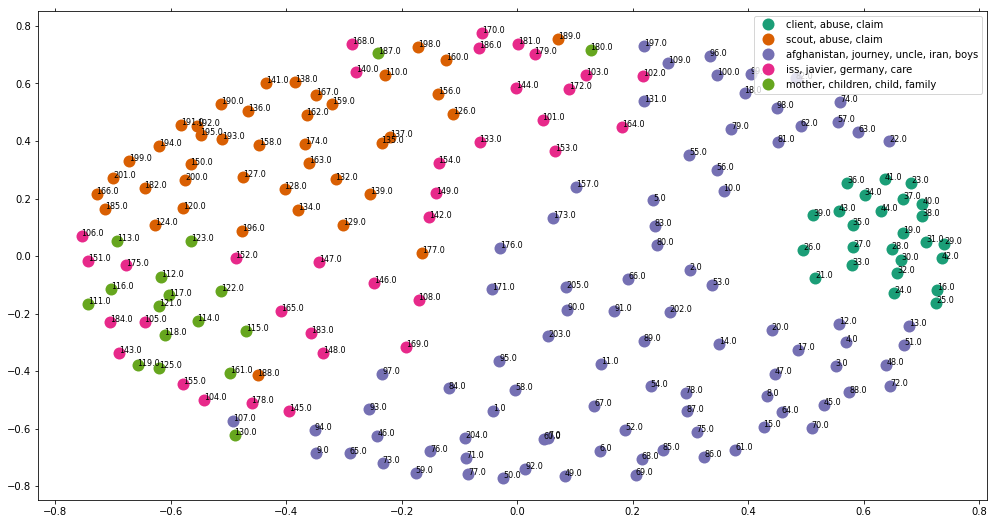

In [ ]:
#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
# df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles))
df_1 = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=df.ID))

#group by cluster
groups = df_1.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point


#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df_1.loc[i]['x'], df_1.loc[i]['y'], df_1.loc[i]['title'], size=8)  

    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)

### Legal-Bert Test